In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torchvision
from torchvision.transforms import v2
import torch
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

#### Gibbs

In [ ]:
def add_gaussian_noise(image, sigma=25):
    noise = np.random.normal(0, sigma, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255)

def mrf_denoise_icm(noisy_img, lambda_smooth, iterations=10):
    """
    Implements MRF denoising using Iterative Conditional Modes (ICM).
    
    noisy_img: The input noisy image (Y)
    lambda_smooth: Weight of the smoothness prior (Higher = smoother/blurrier)
    iterations: How many times to sweep over the image
    """
    # 1. Initialize X (Latent Image) with Y (Noisy Image)
    # We use float to avoid overflow during calculations
    X = noisy_img.astype(float)
    h, w = X.shape
    
    # 2. Iterate
    for it in range(iterations):
        # Create a copy to update values synchronously (or update in-place for asynchronous)
        X_new = X.copy()
        
        for r in range(h):
            for c in range(w):
                # 3. Identify Neighbors (Handle boundaries)
                neighbors = []
                if r > 0: neighbors.append(X[r-1, c])   # Up
                if r < h-1: neighbors.append(X[r+1, c]) # Down
                if c > 0: neighbors.append(X[r, c-1])   # Left
                if c < w-1: neighbors.append(X[r, c+1]) # Right
                
                neighbor_sum = sum(neighbors)
                num_neighbors = len(neighbors)
                
                # 4. Apply Update Rule
                # Derivation: Minimizing (x - y)^2 + lambda * sum((x - n)^2)
                # Solution: x = (y + lambda * sum(neighbors)) / (1 + lambda * num_neighbors)
                
                y_val = noisy_img[r, c]
                
                # Note: The factor '2' from the derivative often cancels out or is absorbed 
                # into lambda, but here is the simplified weighted average form:
                numerator = y_val + (lambda_smooth * neighbor_sum)
                denominator = 1 + (lambda_smooth * num_neighbors)
                
                X_new[r, c] = numerator / denominator
        
        # Check for convergence
        diff = np.mean(np.abs(X_new - X))
        print(f"Iteration {it+1}/{iterations}, Change: {diff:.4f}")
        
        X = X_new

    return np.clip(X, 0, 255).astype(np.uint8)

img_shape = (640, 640)
# Read all images
reshape = v2.Resize(img_shape)
img_path = os.path.join("../../data/Set12/test", '08.png')
target = torchvision.io.decode_image(img_path, torchvision.io.ImageReadMode.GRAY)
target = reshape(target)
print(f"Loaded target image")
# Create noisy version of target image
noise_std = 50
noise = torch.randn_like(target, dtype=torch.float32) * noise_std
noisy = torch.clamp(target.float() + noise, 0, 255).to(torch.float64)
print(f"Created noisy image with noise std={noise_std}")

target = target.numpy()
noisy = noisy.numpy()


# # Add salt and pepper noise
# salt_pepper_prob = 0.05  # probability of salt and pepper noise
# salt_pepper_mask = torch.rand_like(target, dtype=torch.float32)

# # Add salt (white pixels)
# salt_mask = salt_pepper_mask < (salt_pepper_prob / 2)
# noisy[salt_mask] = 255.0

# # Add pepper (black pixels)
# pepper_mask = salt_pepper_mask > (1 - salt_pepper_prob / 2)
# noisy[pepper_mask] = 0.0

# print(f"Added salt and pepper noise with probability={salt_pepper_prob}")
denoised = mrf_denoise_icm(noisy.squeeze(), lambda_smooth=1.5, iterations=5)

# Calculate PSNR as per your evaluation metrics
# psnr = cv2.PSNR(target, denoised)
# print(f"PSNR: {psnr}")

Text(0.5, 1.0, 'Restored (MCMC)')

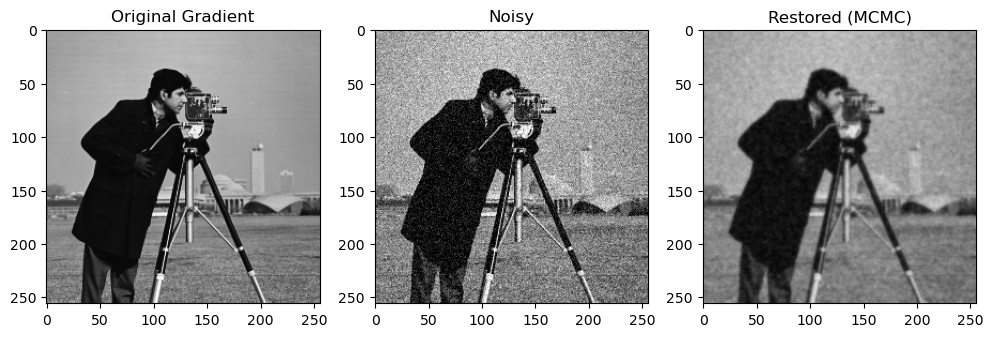

In [89]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img, cmap='gray', vmin=0, vmax=255); ax[0].set_title("Original Gradient")
ax[1].imshow(noisy, cmap='gray', vmin=0, vmax=255); ax[1].set_title("Noisy")
ax[2].imshow(denoised, cmap='gray', vmin=0, vmax=255); ax[2].set_title("Restored (MCMC)")

#### MCMC Metropolis-Hastings

Loaded target image
Created noisy image with noise std=50


  0%|          | 0/50000000 [00:00<?, ?it/s]/var/folders/ms/lvhkg1ns0z1bhb39n9bmf2s40000gn/T/ipykernel_57889/3258353823.py:57: RuntimeWarning: overflow encountered in exp
  acceptance_prob = np.exp(-delta_E)
  0%|          | 2813/50000000 [00:00<29:37, 28124.13it/s]

Currently:5000
PSNR 14.569312640195836,
SSIM: 0.1617691208522077


  4%|▍         | 2009976/50000000 [00:28<11:44, 68134.71it/s]

Currently:5000
PSNR 15.06769443783915,
SSIM: 0.1753268676874626


  8%|▊         | 4013687/50000000 [00:57<13:15, 57842.21it/s] 

Currently:5000
PSNR 15.57312582035548,
SSIM: 0.18989523692108892


 12%|█▏        | 6012416/50000000 [01:26<11:54, 61587.41it/s] 

Currently:5000
PSNR 16.08379778023402,
SSIM: 0.2054189373883184


 16%|█▌        | 8008775/50000000 [01:54<10:28, 66843.76it/s] 

Currently:5000
PSNR 16.600854816881213,
SSIM: 0.2220585928792752


 20%|██        | 10010410/50000000 [02:22<09:55, 67164.52it/s]

Currently:5000
PSNR 17.123348503865152,
SSIM: 0.23988876810776028


 24%|██▍       | 12007944/50000000 [02:50<09:32, 66325.20it/s]

Currently:5000
PSNR 17.65137705721406,
SSIM: 0.25881841066547123


 28%|██▊       | 14011344/50000000 [03:18<09:20, 64160.22it/s] 

Currently:5000
PSNR 18.182755075755686,
SSIM: 0.27894356221956457


 32%|███▏      | 16006201/50000000 [03:47<11:01, 51424.45it/s] 

Currently:5000
PSNR 18.71353823701761,
SSIM: 0.30010813954470555


 36%|███▌      | 18009095/50000000 [04:15<09:00, 59155.22it/s] 

Currently:5000
PSNR 19.243004158769978,
SSIM: 0.32226088947482756


 40%|████      | 20009129/50000000 [04:44<07:28, 66905.21it/s] 

Currently:5000
PSNR 19.767165865708275,
SSIM: 0.3451119289870758


 44%|████▍     | 22015487/50000000 [05:12<06:29, 71862.89it/s]

Currently:5000
PSNR 20.2836568339243,
SSIM: 0.36860615967330335


 48%|████▊     | 24011044/50000000 [05:39<06:36, 65578.70it/s] 

Currently:5000
PSNR 20.791244942787074,
SSIM: 0.39249469542872945


 52%|█████▏    | 26009267/50000000 [06:07<05:57, 67069.29it/s] 

Currently:5000
PSNR 21.283667320616235,
SSIM: 0.41640456581496543


 56%|█████▌    | 28012498/50000000 [06:36<16:01, 22858.39it/s] 

Currently:5000
PSNR 21.76188246191885,
SSIM: 0.4404764442021713


 60%|██████    | 30013159/50000000 [07:05<04:52, 68363.33it/s]

Currently:5000
PSNR 22.220930795877237,
SSIM: 0.46404718433763126


 64%|██████▍   | 32009892/50000000 [07:32<04:18, 69689.36it/s] 

Currently:5000
PSNR 22.65615964385059,
SSIM: 0.48683032270473475


 68%|██████▊   | 34015295/50000000 [07:59<03:51, 69110.22it/s] 

Currently:5000
PSNR 23.06434500542401,
SSIM: 0.5084862053270596


 72%|███████▏  | 36008215/50000000 [08:27<03:11, 73160.47it/s] 

Currently:5000
PSNR 23.442376033131225,
SSIM: 0.5286328570142516


 76%|███████▌  | 38009089/50000000 [08:55<03:08, 63749.86it/s] 

Currently:5000
PSNR 23.79124033111267,
SSIM: 0.5472701988577247


 80%|████████  | 40008882/50000000 [09:24<04:18, 38696.43it/s]

Currently:5000
PSNR 24.105127061762047,
SSIM: 0.5639832409809342


 84%|████████▍ | 42010064/50000000 [09:53<02:06, 63220.53it/s] 

Currently:5000
PSNR 24.38840515487467,
SSIM: 0.578852567332165


 88%|████████▊ | 44011528/50000000 [10:21<01:24, 70553.76it/s]

Currently:5000
PSNR 24.638538366758716,
SSIM: 0.5918719701934932


 92%|█████████▏| 46008950/50000000 [10:49<01:01, 65236.54it/s] 

Currently:5000
PSNR 24.85618112068723,
SSIM: 0.6029414491754658


 96%|█████████▌| 48014462/50000000 [11:16<00:18, 107935.17it/s]

Currently:5000
PSNR 25.03958027894488,
SSIM: 0.6120427422264649


100%|██████████| 50000000/50000000 [11:32<00:00, 72211.76it/s] 


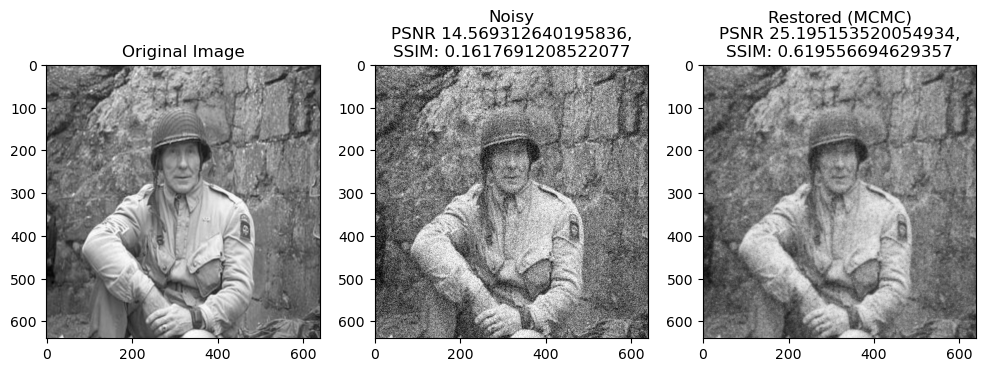

In [ ]:
def calculate_energy(val, neighbors, original_val, beta):
    """
    Calculates the 'Badness' of a pixel value.
    Lower energy = Better fit.
    """
    # 1. Smoothness (Difference from neighbors squared)
    neighbor_energy = 0
    for n_val in neighbors:
        neighbor_energy += (val - n_val)**2
        
    # 2. Fidelity (Difference from original data squared)
    data_energy = (val - original_val)**2
    
    return neighbor_energy + (beta * data_energy)

def mcmc_denoise_grayscale(noisy_img, iterations=500000, beta=0.01):
    """
    beta: Smoothness weight (Lowers contrast between neighbors)
    eta:  Data trust weight
    """
    current_img = noisy_img.copy().astype(float)
    h, w = current_img.shape
    
    pbar = tqdm(total = iterations)
    
    for step in range(iterations):
        # A. Pick Random Pixel
        i, j = np.random.randint(0, h), np.random.randint(0, w)
        
        # Get neighbors' values
        neighbors = []
        if i > 0: neighbors.append(current_img[i-1, j])
        if i < h-1: neighbors.append(current_img[i+1, j])
        if j > 0: neighbors.append(current_img[i, j-1])
        if j < w-1: neighbors.append(current_img[i, j+1])
        
        # B. Current State
        current_val = current_img[i, j]
        original_val = noisy_img[i, j]
        
        # C. Propose a new value (Random Walk)
        # We add a random number between -10 and +10 roughly
        proposal = current_val + np.random.normal(0, 2)
        
        # Clip to ensure valid range 0-255
        proposal = np.clip(proposal, 0, 255)

        # D. Calculate Energy of both options
        energy_current = calculate_energy(current_val, neighbors, original_val, beta)
        energy_proposal = calculate_energy(proposal, neighbors, original_val, beta)
        
        # E. Metropolis-Hastings Acceptance Step
        # If proposal has lower energy, delta_E is negative -> exp is > 1 -> Accept
        # If proposal has higher energy, exp is between 0 and 1 -> Chance to Accept
        delta_E = energy_proposal - energy_current
        
        acceptance_prob = np.exp(-delta_E)
        
        if np.random.rand() < acceptance_prob:
            current_img[i, j] = proposal
        
        if (step % 2000000) == 0:
            print(f"Currently:5000\nPSNR {psnr(target, current_img, data_range=255)},\nSSIM: {ssim(target, current_img, data_range=255)}")
        pbar.update(1)

    return current_img

img_shape = (640, 640)
reshape = v2.Resize(img_shape)
img_path = os.path.join("../../data/BSDS300/images/test", 'test008.jpeg')
target = torchvision.io.decode_image(img_path, torchvision.io.ImageReadMode.GRAY)
target = reshape(target)
print(f"Loaded target image")
# Create noisy version of target image
noise_std = 50
noise = torch.randn_like(target, dtype=torch.float32) * noise_std
noisy = torch.clamp(target.float() + noise, 0, 255).to(torch.float64)
print(f"Created noisy image with noise std={noise_std}")

target = target.numpy().squeeze()
noisy = noisy.numpy().squeeze()


# Denoise
denoised_img = mcmc_denoise_grayscale(noisy, iterations=50000000, beta=0.5)

# Plot
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(target, cmap='gray', vmin=0, vmax=255); ax[0].set_title("Original Image")
ax[1].imshow(noisy, cmap='gray', vmin=0, vmax=255); ax[1].set_title(f"Noisy\nPSNR {psnr(target, noisy, data_range=255)},\nSSIM: {ssim(target, noisy, data_range=255)}")
ax[2].imshow(denoised_img, cmap='gray', vmin=0, vmax=255); ax[2].set_title(f"Restored (MCMC)\nPSNR {psnr(target, denoised_img, data_range=255)},\nSSIM: {ssim(target, denoised_img, data_range=255)}")
plt.show()